# Bayesian Statistics with PyMC3 and Edward

## Taylor Smith and Jonathan Hayne

# Overview:

## Introduction to Bayesian Statistics

## Coding Example with PyMC3

## Coding Example with Edward

# Philosophical Introduction

### Frequentist

* Defines probability as the limit of the relative frequency in  large number of trials

* Based on the idea of infinitely repeatable data generating process

* Views parameters as fixed and the data as random

### Bayesian

* Probability is defined as a subjective degree of belief concerning whether the event will occur.

* An expression of uncertainity

* Data is viewed as fixed with the parameters randomly distributed

# Philosophical Introduction


$$P( \theta | \mathbf{X}) \propto L(\theta | \mathbf{X}) P(\theta)$$

* Prior - represents our prior beliefs about $\theta$ before seeing the data. 

* Likelihood - represents what the data has to say about the possible values of $\theta$

* Posterior - compromise between prior & likelihood

# Basic Overview:

* Three general steps to a Bayesian model:
    1. Specify a probability model incorporating whatever prior knowledge you may have
    2. Update by conditioning on the data.
    3. Evaluate the fit of the model and whether the assumptions are properly met

# Inference
 * The posterior is often intractable (cannot be analytically solved) for all but very simple models.
 
 * This held Bayesian statistics back for a long time.
 
 * With advance of computational power, Bayesian statistics has massively grown in popularity
 
 * Two popular methods: Markov Chain Monte Carlo (MCMC) and Variational Inference

# MCMC

* Method for sampling from a distribution using Markov Chains that have the desired distribution as it's equilibrium distribution.

* Guaranteed to converge eventually

* Can take a very long time.

* Takes many shapes and forms. Most notable includes Gibbs sampling, Metropolis-Hastings, and Hamiltonian Monte Carlo

# Variational Inference

* "Variational Inference is that thing you implement while waiting for your Gibbs sampler to converge" - David Blei

* Approximates an intractable distribution with a tractable one

* Much faster

* Will be biased

# Hierarchical/Multilevel Models

* One of the greatest strengths of the Bayesian framework

* Useful when you have multiple levels within your data: counties in a state, documents in a corpus, players on a team, students in a class, class within the school.

* Sharing statistical strength/shrinkage.

# Hierarchical/Multilevel Models

* Can be extended to a very wide variety of very complex models (Hierarchical Latent Dirichlet Allocation, Hierarchical Neural Networks, Hierarchical Dirichlet Process Hidden Semi-Markov Models).

* We will keep it simple and implement a hierarchical linear model in both PyMC3 and Edward

# PyMC3

* "A Python package for Bayesian statistical modeling and Probabilistic Machine Learning which focuses on advanced Markov chain Monte Carlo and variational fitting algorithms"
* Very intuitive model specification
* Relies on and plays well with Theano

# Edward
 * "Python library for probabilistic modeling, inference, and criticism"
 * "Edward fuses three fields: Bayesian statistics and machine learning, deep learning, and probabilistic programming."
 * Very flexible

# Coding Example

* Classic hierarchical dataset: radon levels within houses in Minnesota
* Target variable: radon level
* Explanatory variable: county and whether the measurement was taken in the basement or the first floor

# Models

* We will fit three separate models.
    * One where we pool all the counties and fit a single regression. 
    * One where we fit a separate regression for each county
    * A hierarchical model where we have varying intercept and slope by county but where these are explictly modeled as realizations of a distribution on the intercept and slope.
* Notationally, we can represent the models as such:
    * $$radon_{i,c} = \beta_0 + floor_{i,c} * \beta_1 + \epsilon$$
    * $$radon_{i,c} = \beta_{0,c} + floor_{i,c} * \beta_{1, c} + \epsilon$$
    * $$\beta_{0,c} \sim N(\mu_0, \sigma^2_0) $$ $$\beta_{1,c} \sim N(\mu_1, \sigma^2_1)$$ $$radon_{i,c} = \beta_{0,c} + floor_{i,c} * \beta_{1, c} + \epsilon$$

* The last model should perform the best.
    * We believe there are likely differences in between counties, so the first model is not good.
    * We believe that there is enough shared structure between counties that ignoring all the other points outside of a county is poor practice.
    * Last is a compromise between the two, acknowledges differences but also recognizes that they should be related to one another.
* These models represent complete pooling, no pooling, and partial pooling respectively
    

In [89]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt

radon = pd.read_csv(pm.get_data('radon.csv'))

county_names = radon.county.unique()
county_idx = radon['county_code'].values
n_counties = len(radon.county.unique())
total_size = len(radon)

In [77]:
#Model with complete pooling
#Extracting variables
radon_vals = radon.log_radon
floor_vals = radon.floor.values

#Running the model:
with pm.Model() as full_pool:
    #Specifying the Intercept Prior
    b0 = pm.Normal('b0', mu = 0, sd = 1)
    
    #Specifying the slope prior
    b1 = pm.Normal('b1', mu = 0, sd =1)
    
    #Prior on the variance
    eps = pm.HalfCauchy('eps', beta = 1)
    
    #Specifying the model form
    radon_est = b0 + b1 * floor_vals
    
    #Specifying the likelihood
    pm.Normal('y_like', mu = radon_est, sd = eps, observed = radon_vals)
    
    pooled_trace = pm.sample(progressbar = False)
    #If you want to use variational inference instead
    #variational_fit = pm.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Convergence archived at 11800
Interrupted at 11,800 [5%]: Average Loss = 1,572.8


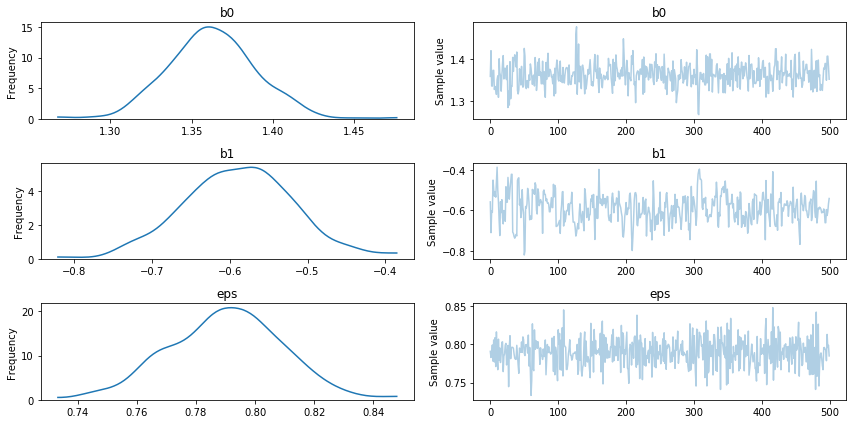

In [91]:
pooled_plot = pm.traceplot(pooled_trace)

In [79]:
#Model 2
#To store each individual model
county_traces = {}

#Looping through each county and fitting a model
for county_name in county_names:
    #Data Frame for each individual county
    county_data = radon.loc[radon.county == county_name].reset_index(drop = True)
    
    #Extracting the radon level and the floor
    county_radon = county_data.log_radon
    county_floor = county_data.floor.values
    
    #Modelling
    with pm.Model() as individual:
        #Specifying Intercept prior
        b0 = pm.Normal('b0', mu = 0, sd = 1)

        #Specifying Slope Prior
        b1 = pm.Normal('b1', mu = 0, sd = 1)

        # Specifying error prior
        eps = pm.HalfCauchy('eps', beta = 1)

        #Specifying our linear model
        radon_est = b0 + b1 * county_floor

        #Specifying the likelihood
        y_likelihood = pm.Normal('y_like', mu = radon_est,
                                 sd = eps, observed = county_radon)

        #Performing the inference sampling via MCMC
        trace = pm.sample(progressbar = False)
    
    county_traces[county_name] = trace

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Convergence archived at 1500
Interrupted at 1,500 [0%]: Average Loss = 8.6862
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Convergence archived at 10100
Interrupted at 10,100 [5%]: Average Loss = 81.082
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Convergence archived at 1500
Interrupted at 1,500 [0%]: Average Loss = 8.9268
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Convergence archived at 4100
Interrupted at 4,100 [2%]: Average Loss = 18.307
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Convergence archived at 3600
Interrupted at 3,600 [1%]: Average Loss = 10.096
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Convergence archived at 4600
Interrupted at 4,600 [2%]: Average Loss = 8.2295
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Convergence archived at 11800
Interrupted at 11,800 [5%]: Average Loss = 29.503
Auto-assi

Initializing NUTS using ADVI...
Convergence archived at 5900
Interrupted at 5,900 [2%]: Average Loss = 26.573
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Convergence archived at 4600
Interrupted at 4,600 [2%]: Average Loss = 18.029
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Convergence archived at 6200
Interrupted at 6,200 [3%]: Average Loss = 34.834
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Convergence archived at 4600
Interrupted at 4,600 [2%]: Average Loss = 11.277
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Convergence archived at 1500
Interrupted at 1,500 [0%]: Average Loss = 6.6853
/Users/tbsmith/anaconda/envs/py36/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 2 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...

/Users/tbsmith/anaconda/envs/py36/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 14 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Convergence archived at 11800
Interrupted at 11,800 [5%]: Average Loss = 27.503
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Convergence archived at 10100
Interrupted at 10,100 [5%]: Average Loss = 26.292
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Convergence archived at 3000
Interrupted at 3,000 [1%]: Average Loss = 5.2918
/Users/tbsmith/anaconda/envs/py36/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.676299396005, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, targ

In [70]:
#Hierarchical Model
with pm.Model() as hierarchical_model:
    #Setting our hyperpriors over the population of b0 and b1
    mu_0 = pm.Normal('mu_0', mu = 0, sd = 1)
    sigma_0 = pm.HalfCauchy('sigma_0', beta = 1)
    mu_1 = pm.Normal('mu_1', mu = 0, sd =1)
    sigma_1 = pm.HalfCauchy('sigma_1', beta = 1)
    
    #Drawing a value of b0 and b1 for each county around population mean
    b0 = pm.Normal('b0', mu = mu_0, sd = sigma_0,
                   shape = n_counties)
    b1 = pm.Normal('b1', mu = mu_1, sd = sigma_1,
                   shape = n_counties)
    
    #Model error
    eps = pm.HalfCauchy('eps', beta = 1)
    
    #Expected value
    radon_est = b0[county_idx] + b1[county_idx] * radon.floor.values
    
    #Specifying the likelihood model
    y_likelihood = pm.Normal('y_like', mu = radon_est,
                             sd = eps, observed = radon.log_radon)

In [71]:
with hierarchical_model:
    hierarchical_trace = pm.sample(njobs = 4)
    
    #If using variational inference
    #hierarchical_fit = pm.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 1,079.4:  10%|▉         | 19488/200000 [00:05<00:56, 3178.59it/s]
Convergence archived at 19500
Interrupted at 19,500 [9%]: Average Loss = 1,441.9
100%|██████████| 1000/1000 [00:24<00:00, 40.04it/s]
/Users/tbsmith/anaconda/envs/py36/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 3 does not match the target. It is 0.691615279798, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/tbsmith/anaconda/envs/py36/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 3 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
/Users/tbsmith/anaconda/envs/py36/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability i

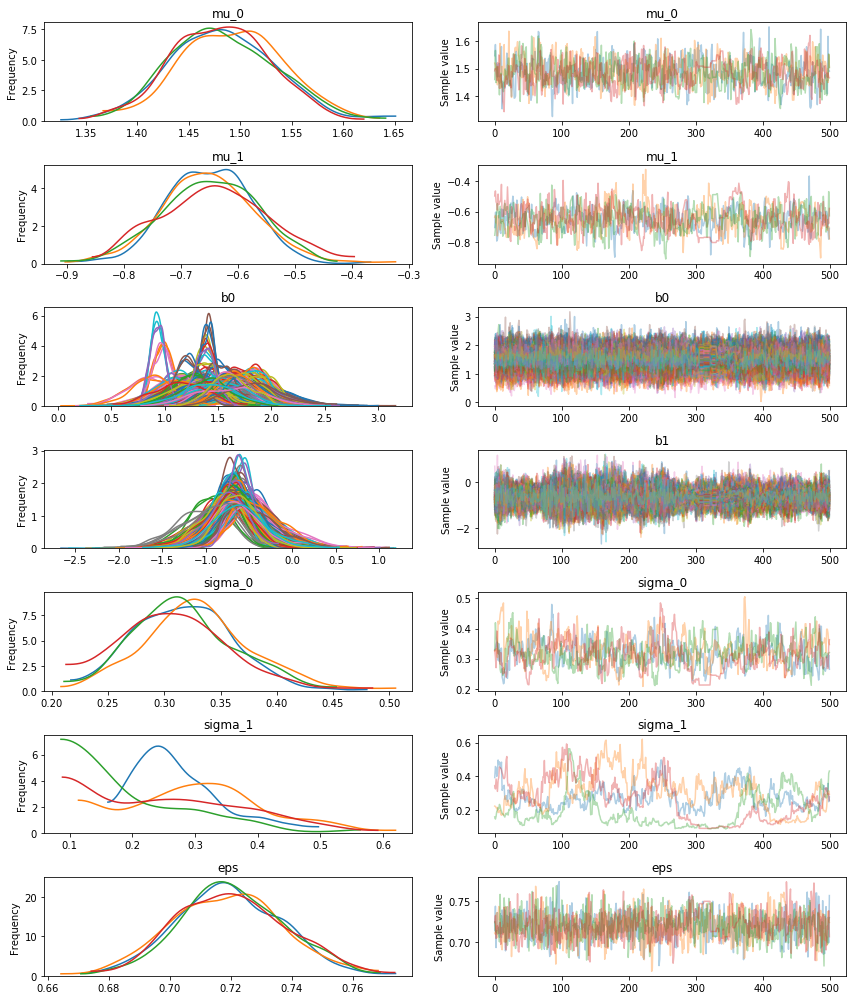

In [90]:
plot = pm.traceplot(hierarchical_trace)

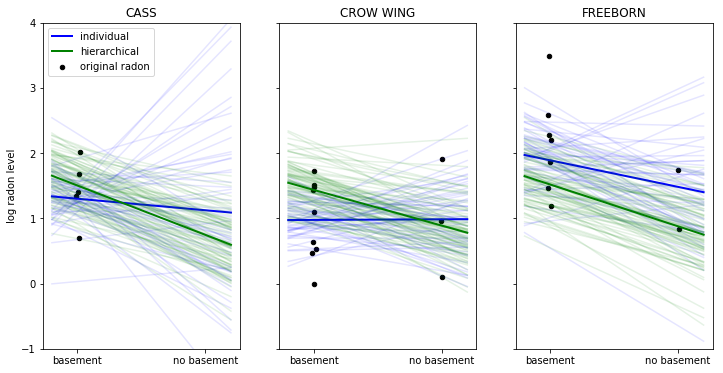

In [100]:
selection = ['CASS', 'CROW WING', 'FREEBORN']
fig, axis = plt.subplots(1, 3, figsize=(12, 6), sharey=True, sharex=True)
axis = axis.ravel()
for i, c in enumerate(selection):
    c_radon = radon.loc[radon.county == c]
    c_radon = c_radon.reset_index(drop = True)
    z = list(c_radon['county_code'])[0]

    xvals = np.linspace(-0.2, 1.2)
    for a_val, b_val in zip(county_traces[c]['b0'][::10], county_traces[c]['b1'][::10]):
        axis[i].plot(xvals, a_val + b_val * xvals, 'b', alpha=.1)
    axis[i].plot(xvals, county_traces[c]['b0'][::10].mean() + county_traces[c]['b1'][::10].mean() * xvals, 
                 'b', alpha=1, lw=2., label='individual')
    for a_val, b_val in zip(hierarchical_trace['b0'][::10][z], hierarchical_trace['b1'][::10][z]):
        axis[i].plot(xvals, a_val + b_val * xvals, 'g', alpha=.1)
    axis[i].plot(xvals, hierarchical_trace['b0'][::10][z].mean() + hierarchical_trace['b1'][::10][z].mean() * xvals, 
                 'g', alpha=1, lw=2., label='hierarchical')
    axis[i].scatter(c_radon.floor + np.random.randn(len(c_radon))*0.01, c_radon.log_radon, 
                    alpha=1, color='k', marker='.', s=80, label='original radon')
    axis[i].set_xticks([0,1])
    axis[i].set_xticklabels(['basement', 'no basement'])
    axis[i].set_ylim(-1, 4)
    axis[i].set_title(c)
    if not i%3:
        axis[i].legend()
        axis[i].set_ylabel('log radon level')

In [99]:
plt.ioff()

In [85]:
hier_a = hierarchical_trace['b0'].mean(axis=0)
hier_b = hierarchical_trace['b1'].mean(axis=0)
indv_a = [county_traces[c]['b0'].mean() for c in county_names]
indv_b = [county_traces[c]['b1'].mean() for c in county_names]

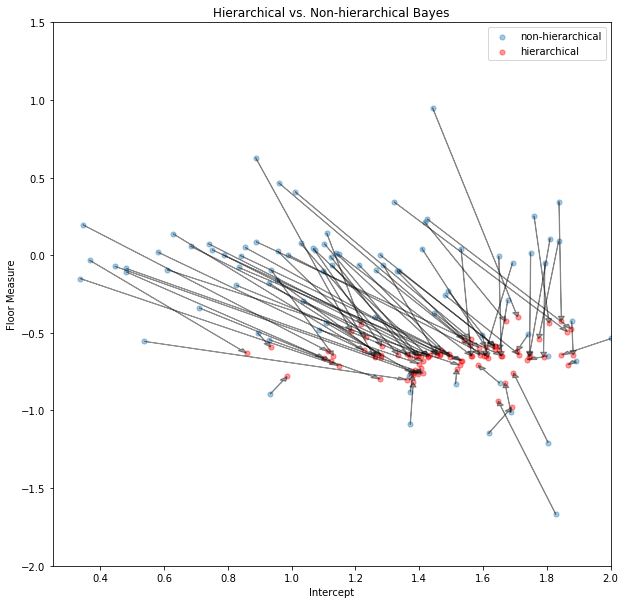

In [86]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, xlabel='Intercept', ylabel='Floor Measure', 
                     title='Hierarchical vs. Non-hierarchical Bayes', 
                     xlim=(0.25, 2), ylim=(-2, 1.5))

ax.scatter(indv_a,indv_b, s=26, alpha=0.4, label = 'non-hierarchical')
ax.scatter(hier_a,hier_b, c='red', s=26, alpha=0.4, label = 'hierarchical')
for i in range(len(indv_b)):  
    ax.arrow(indv_a[i], indv_b[i], hier_a[i] - indv_a[i], hier_b[i] - indv_b[i], 
             fc="k", ec="k", length_includes_head=True, alpha=0.4, head_width=.02)
ax.legend();